# Download input data at the link below and save it to ./data/


https://drive.google.com/file/d/1gtPF0G1UMKGCiKNfq_zziduyxo9Vmr5V/view?usp=sharing

# Download Feature Selector script here

https://github.com/jhabib/w210/blob/master/feature_selector.py

# Process Categorical data for use in models

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Categorical data (Categorical)

In [2]:
cat_data = pd.read_csv('./data/categorical_features.csv', low_memory=False, dtype=int)
cat_data = cat_data.drop('Unnamed: 0', axis=1)
cat_data['id'] = cat_data['id'].astype(int)
cat_data = cat_data.astype(bool)
print cat_data.shape

(243721, 99)


# Load Reviews Data (Dependent variable)

In [3]:
reviews_data = pd.read_csv('./data/reviews_features.csv', low_memory=False, dtype=float)
reviews_data = reviews_data.drop('Unnamed: 0', axis=1)
reviews_data['id'] = reviews_data['id'].astype(int).astype("category")
print reviews_data.shape

(243721, 5)


# Get Random Sample for use in EDA

In [4]:
# select random rows
import numpy as np

np.random.seed(1234)
sample_size=5000
idxs = np.random.randint(0, cat_data.shape[0], sample_size)
idxs

array([224047, 189139, 165158, ..., 198969, 190231,   2508])

# Select Dependent Variable

In [23]:
dependent_variable = 'review_scores_rating'

data = pd.concat([cat_data.loc[idxs], reviews_data.loc[idxs][[dependent_variable]]], axis=1)
print data.shape
print data.columns[:5]

data = data.drop(['id'], axis=1)
data = data.dropna(subset=[dependent_variable])

print data.shape

(5000, 100)
Index([u'id', u'bed_type_airbed', u'bed_type_couch', u'bed_type_futon',
       u'bed_type_pull_out_sofa'],
      dtype='object')
(3860, 99)


# Histogram of each dependent variable
Quite useless for Categorical data

bed_type_airbed


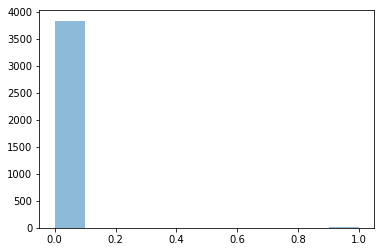

bed_type_couch


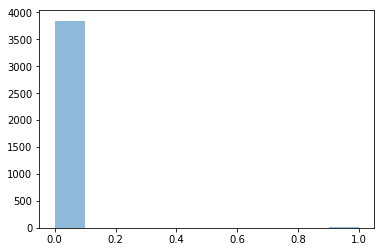

bed_type_futon


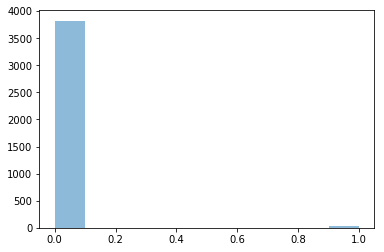

bed_type_pull_out_sofa


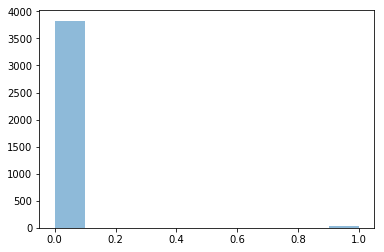

bed_type_real_bed


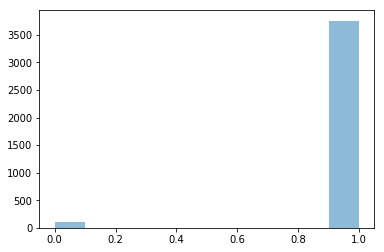

room_type_entire_home_apt


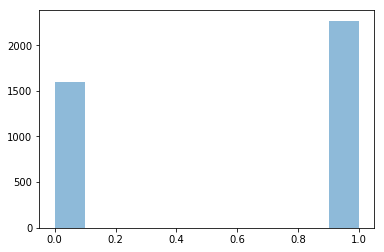

room_type_private_room


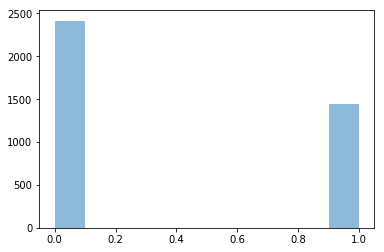

room_type_shared_room


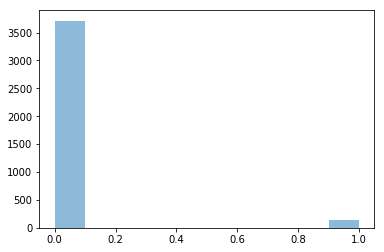

neighbourhood_cleansed_bayview


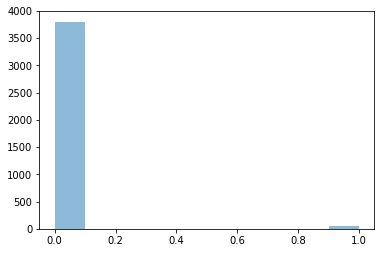

neighbourhood_cleansed_bernal_heights


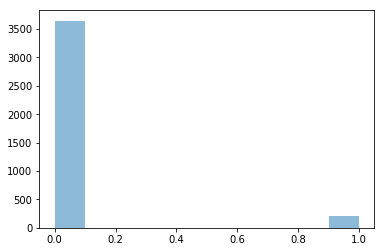

In [7]:
import matplotlib.pyplot as plt
for c in data.columns[:10]:
    if 'id' != c:
        print c
        lst = list(data[c].fillna('0'))
        plt.hist(lst, bins=10, alpha=0.5)
        plt.show()

# Create boxplot of dependent variable for each category

In [8]:
import seaborn as sns


# bed, room, neighbourhood, property, cancellation, host_response
sns.set_style('whitegrid')

bed = []
room = []
neighbourhood = []
prop = []
cancellation = []
host_response = []
for c in data.columns:
    if 'bed_type_' in c:
        bed.append(c)
    elif 'room_type_' in c:
        room.append(c)
    elif 'neighbourhood_cleansed_' in c:
        neighbourhood.append(c)
    elif 'property_type_' in c:
        prop.append(c)
    elif 'cancellation_' in c:
        cancellation.append(c)
    elif 'host_response_' in c:
        host_response.append(c)
        

def create_boxplot(df, columns, dep_cutoff=0.):
    n = len(columns)
    fig, axes = plt.subplots(1, n, 
                             sharex=True, 
                             sharey=True, 
                             squeeze=True, 
                             figsize=(20, 10))
    axes = axes.flatten()
    for ax, c in zip(axes, columns):
        subset = data.loc[data[c] == True]
        subset = subset[[c, dependent_variable]]
        subset = subset.loc[subset[dependent_variable] >= dep_cutoff]
        if not subset[c].empty:
            sns.boxplot(x=subset[c], 
                        y=subset[dependent_variable], 
                        ax=ax, 
                       boxprops=dict(alpha=0.5))

Boxplot of review_scores_rating vs. bed_type


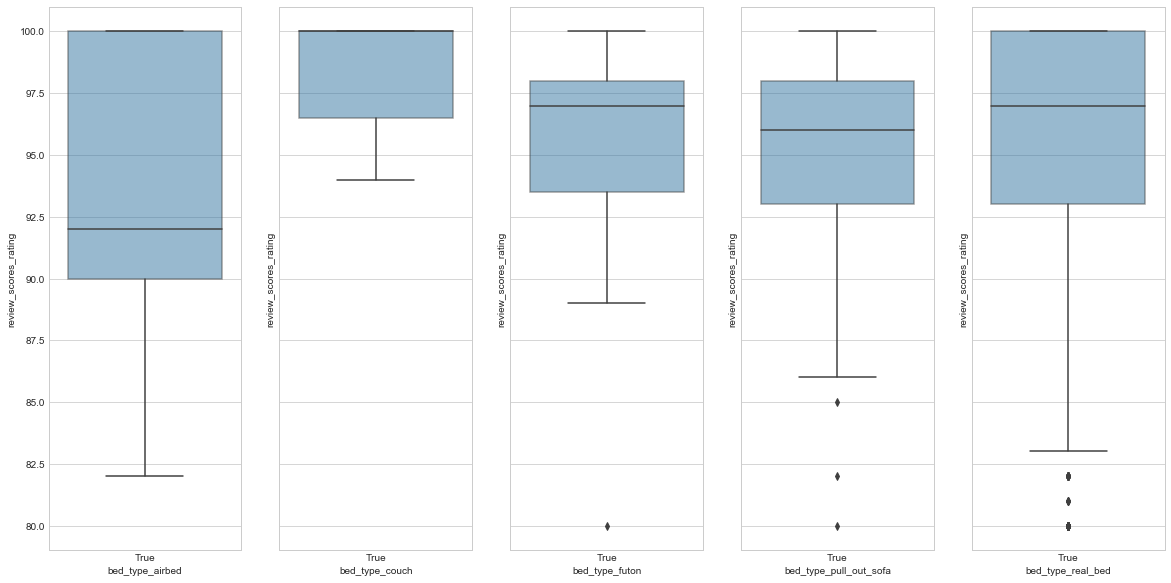

In [9]:
print 'Boxplot of %s vs. %s' % ('review_scores_rating', 'bed_type')
create_boxplot(data, bed, 80)

Boxplot of review_scores_rating vs. room_type


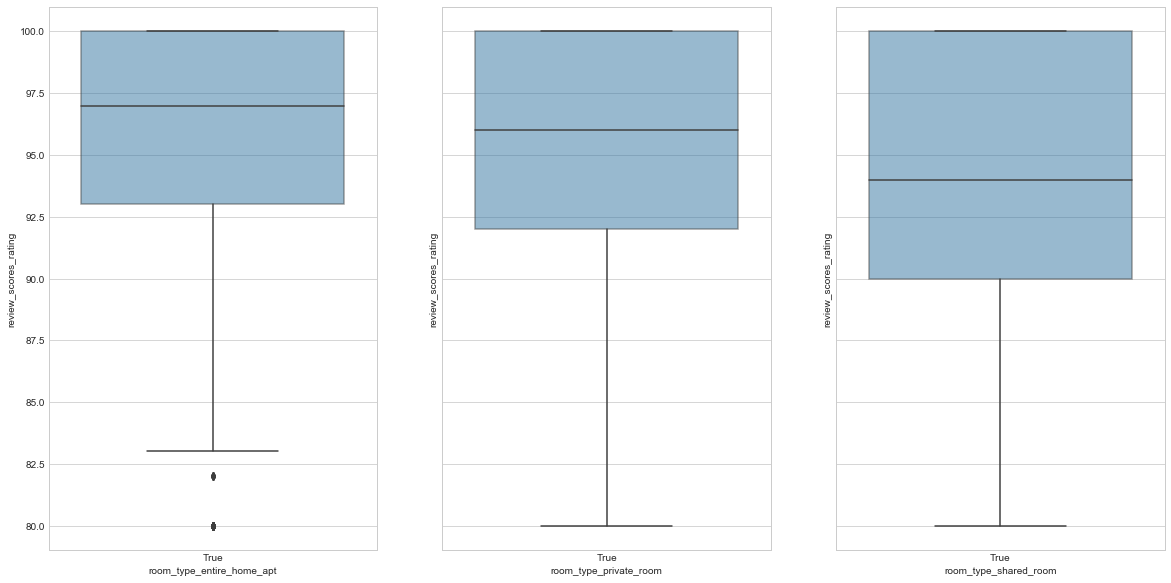

In [10]:
print 'Boxplot of %s vs. %s' % ('review_scores_rating', 'room_type')
create_boxplot(data, room, 80)

Boxplot of review_scores_rating vs. neighbourhood


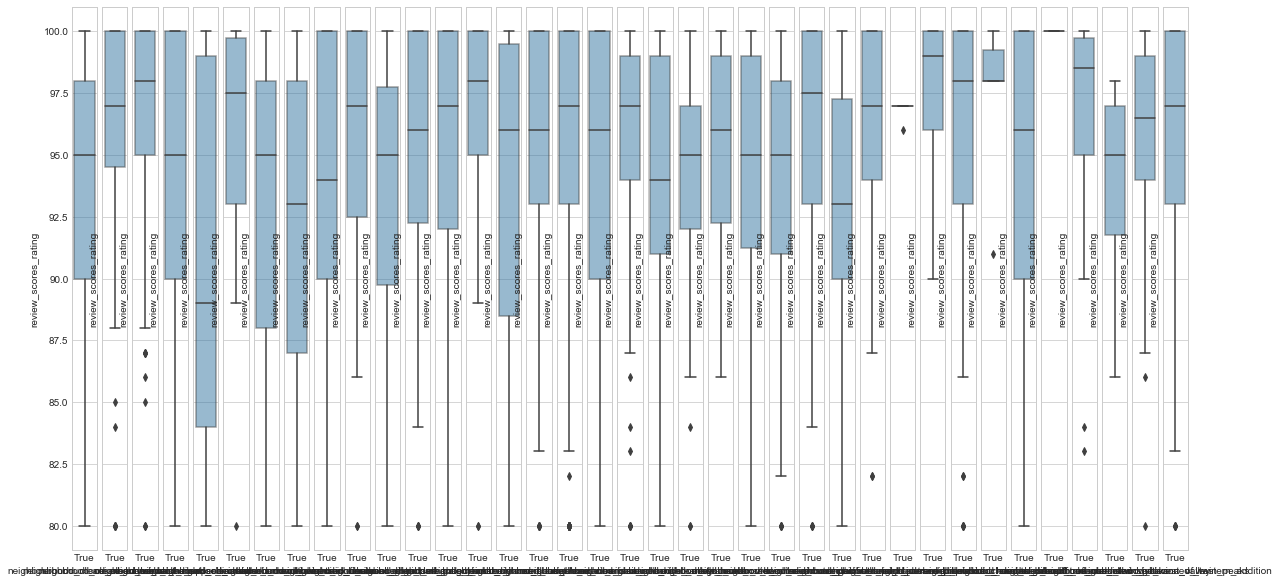

In [11]:
print 'Boxplot of %s vs. %s' % ('review_scores_rating', 'neighbourhood')
create_boxplot(data, neighbourhood, 80)

Boxplot of review_scores_rating vs. property_type


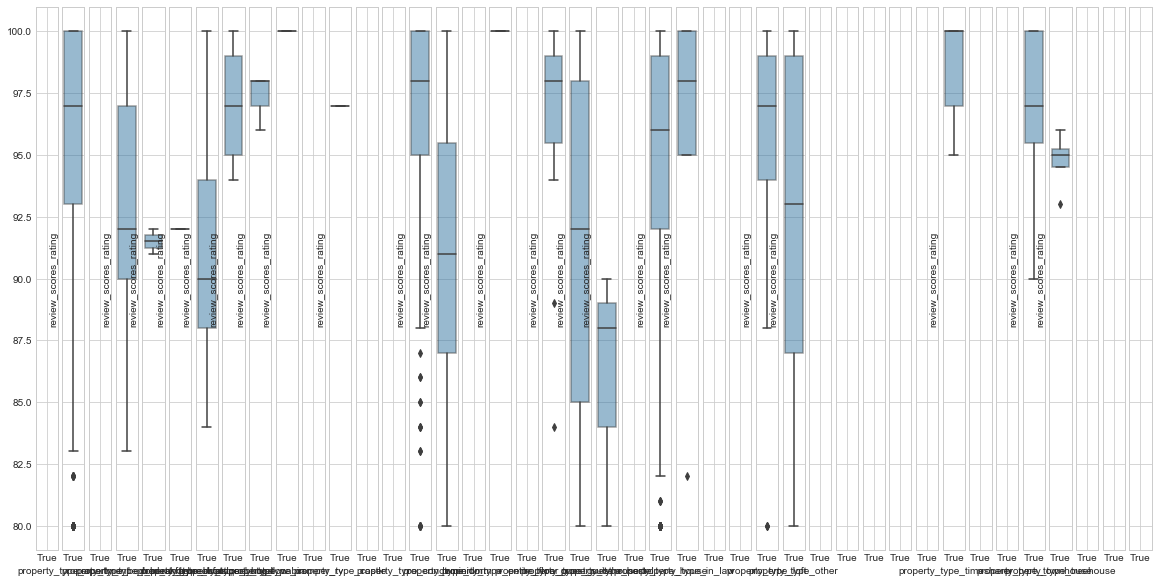

In [12]:
print 'Boxplot of %s vs. %s' % ('review_scores_rating', 'property_type')
create_boxplot(data, prop, 80)

Boxplot of review_scores_rating vs. cancellation_policy


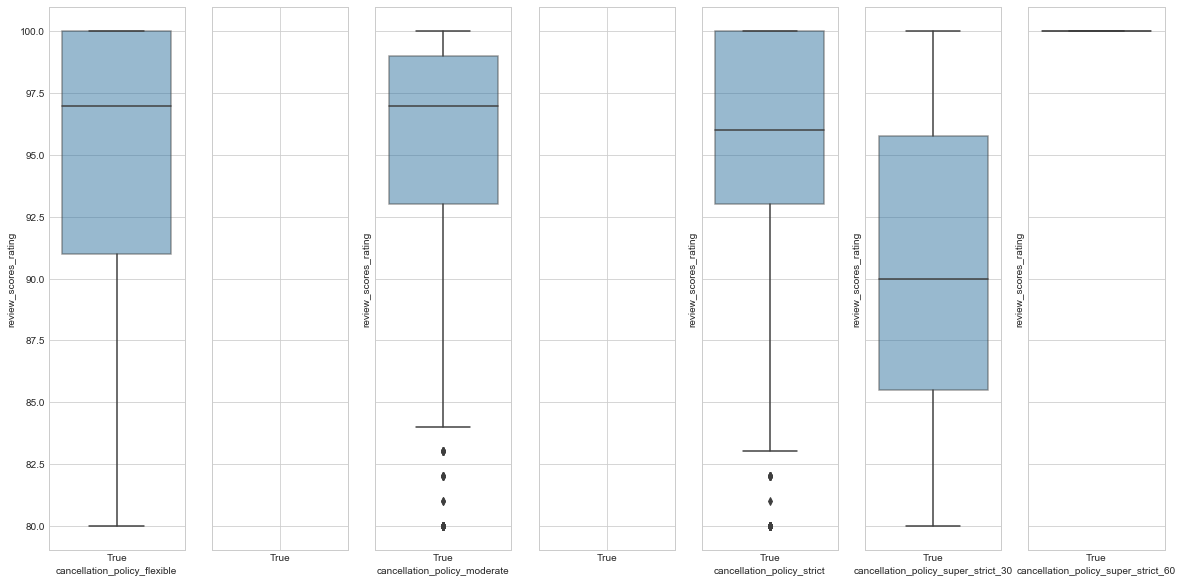

In [13]:
print 'Boxplot of %s vs. %s' % ('review_scores_rating', 'cancellation_policy')
create_boxplot(data, cancellation, 80)

Boxplot of review_scores_rating vs. host_response


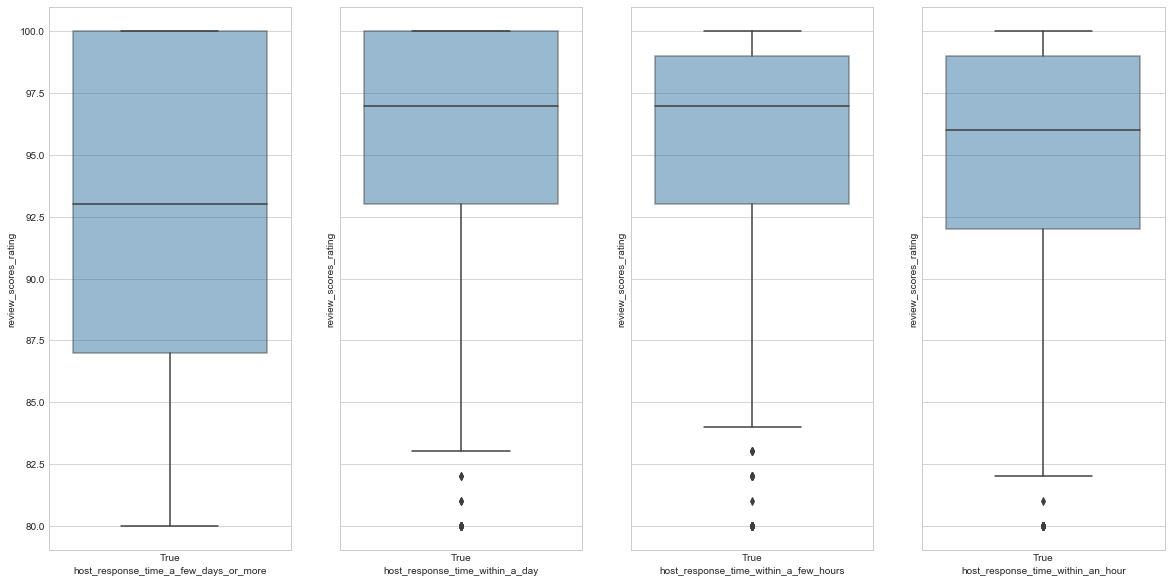

In [14]:
print 'Boxplot of %s vs. %s' % ('review_scores_rating', 'host_response')
create_boxplot(data, host_response, 80)

The boxplots show different quantiles for review_scores_rating for each item in the categorical variable

In [15]:
print data.shape

(3860, 99)


# Separate Dependent and Independent variables

In [24]:
# Create the X and y
# Drop the columns that we do not need
y = data[dependent_variable]
X = data.drop([dependent_variable], axis=1)

print X.shape
print y.shape

(3860, 98)
(3860,)


In [25]:
print X.shape

(3860, 98)


# Create feature interactions

In [26]:
# Create a dictionary of interactions

inter_dct = {}

# bed = []
# room = []
# neighbourhood = []
# prop = []
# cancellation = []
# host_response = []

for n in neighbourhood:
    for p in prop:
        try:
            inter_dct[n].append((p, 'M'))
        except Exception as e:
            inter_dct[n] = [(p, 'M')]

for n in room:
    for p in bed:
        try:
            inter_dct[n].append((p, 'M'))
        except Exception as e:
            inter_dct[n] = [(p, 'M')]
                            

for n in room:
    for p in prop:
        try:
            inter_dct[n].append((p, 'M'))
        except Exception as e:
            inter_dct[n] = [(p, 'M')]

In [27]:
def create_interaction(f1, f2, intyp):
    if 'D' == intype:
        return f1 | f2
    if 'A' == intype:
        return f1 + f2
    
    # Mulitply the features by default
    return f1 & f2

def get_interacted_dataset(ds, interactions_dict, drop=False):
    for k, vals in interactions_dict.items():
        for v in vals:
            ds[k+'_by_'+v[0]] = ds[k] & ds[v[0]]
        
    if drop:
        for k in interactions_dict.keys():
            ds = ds.drop(k, axis=1)
    
    return ds

X = get_interacted_dataset(X, inter_dct, drop=True)

# Remove useless features

In [28]:
# Let's get rid of useless categorical features

from feature_selector import FeatureSelector

fs = FeatureSelector(data=X, 
                     labels=y)
fs.identify_single_unique()
fs.identify_zero_importance(task='regression', eval_metric='rmse')
fs.identify_low_importance(cumulative_importance=0.90)

X = fs.remove(methods=['single_unique', 'low_importance', 'zero_importance'])

1445 features with a single unique value.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[40]	valid_0's rmse: 7.06501
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's rmse: 7.06484
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[314]	valid_0's rmse: 6.43491
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[241]	valid_0's rmse: 7.60462
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's rmse: 6.45108
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[13]	valid_0's rmse: 5.69001
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's rmse: 6.24289
Training until validation scores

# Plot Feature importance using regression

Feature ranking: 
1. bed_type_real_bed 7 (0.092533)
2. property_type_apartment 11 (0.085290)
3. property_type_condominium 35 (0.081099)
4. property_type_dorm 13 (0.073469)
5. property_type_house 9 (0.062396)
6. property_type_other 12 (0.050234)
7. property_type_townhouse 8 (0.047932)
8. cancellation_policy_flexible 3 (0.046364)
9. cancellation_policy_moderate 23 (0.043468)
10. cancellation_policy_strict 20 (0.041007)
11. host_response_time_a_few_days_or_more 36 (0.031177)
12. host_response_time_within_a_day 18 (0.025327)
13. host_response_time_within_a_few_hours 26 (0.021489)
14. host_response_time_within_an_hour 34 (0.020507)
15. neighbourhood_cleansed_bernal_heights_by_property_type_house 28 (0.019580)
16. neighbourhood_cleansed_outer_richmond_by_property_type_house 10 (0.019185)
17. neighbourhood_cleansed_north_beach_by_property_type_apartment 32 (0.016588)
18. neighbourhood_cleansed_financial_district_by_property_type_apartment 42 (0.015048)
19. neighbourhood_cleansed_parkside_by_p

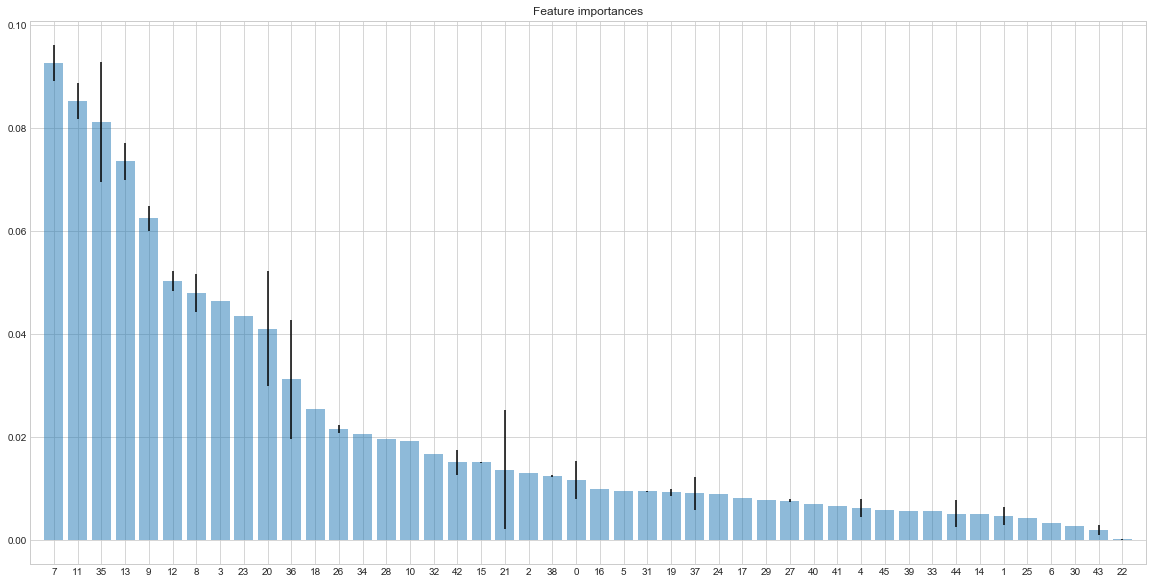

In [29]:
from sklearn.ensemble import ExtraTreesRegressor

forest = ExtraTreesRegressor(n_estimators=250, random_state=1234)

forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], 
             axis=0)

indices = np.argsort(importances)[::-1]

print 'Feature ranking: '


for f, c in zip(range(X.shape[1]), X.columns):
    print '%d. %s %d (%f)' % (f+1, c, indices[f], 
                              importances[indices[f]])


# Plot the feature importances of the forest
plt.figure(figsize=
           (20, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices], align="center", alpha=0.5)
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Processing the final data
In order to create the processed dataset, here's what we will do:
1. Load all the categorical data
2. Split the data into Training and Test sets using random indexes
3. Process the data 
4. Save the Processed into csv files

In [30]:
cat_data = pd.read_csv('./data/categorical_features.csv', low_memory=False, dtype=int)
cat_data = cat_data.drop('Unnamed: 0', axis=1)
cat_data['id'] = cat_data['id'].astype(int)
cat_data = cat_data.astype(bool)
print cat_data.shape

reviews_data = pd.read_csv('./data/reviews_features.csv', low_memory=False, dtype=float)
reviews_data = reviews_data.drop('Unnamed: 0', axis=1)
reviews_data['id'] = reviews_data['id'].astype(int).astype("category")
print reviews_data.shape

(243721, 99)
(243721, 5)


In [31]:
dependent_variable = 'review_scores_rating'

data = pd.concat([cat_data, reviews_data[[dependent_variable]]], axis=1)

data = data.drop(['id'], axis=1)
data = data.dropna(subset=[dependent_variable])

print data.shape
print data.sample(1)

(190004, 99)
       bed_type_airbed  bed_type_couch  bed_type_futon  \
82042            False           False           False   

       bed_type_pull_out_sofa  bed_type_real_bed  room_type_entire_home_apt  \
82042                   False               True                       True   

       room_type_private_room  room_type_shared_room  \
82042                   False                  False   

       neighbourhood_cleansed_bayview  neighbourhood_cleansed_bernal_heights  \
82042                           False                                  False   

               ...           cancellation_policy_moderate  \
82042          ...                                   True   

       cancellation_policy_no_refunds  cancellation_policy_strict  \
82042                           False                       False   

       cancellation_policy_super_strict_30  \
82042                                False   

       cancellation_policy_super_strict_60  \
82042                               

# Create feature interactions

In [40]:
data = get_interacted_dataset(data, inter_dct)
print data.shape

(190004, 1794)


# Split the data into Train and Test

In [41]:
from sklearn.model_selection import train_test_split

Train, Test = train_test_split(data, test_size=0.33, random_state=1234)
train_colnames = Train.columns
test_colnames = Test.columns

print Train.shape
print Test.shape

(127302, 1794)
(62702, 1794)


In [42]:
Train = pd.DataFrame(Train, columns=train_colnames)
Train.sample()
Test = pd.DataFrame(Test, columns=test_colnames)
Test.sample()


# Train data
y_train = Train[dependent_variable]
print y_train.shape

X_train = Train.drop([dependent_variable], axis=1)
print X_train.shape

# Test data
y_test = Test[dependent_variable]
print y_test.shape

X_test = Test.drop([dependent_variable], axis=1)
print X_test.shape

(127302,)
(127302, 1793)
(62702,)
(62702, 1793)


# Run feature selection

In [44]:
from feature_selector import FeatureSelector

fs = FeatureSelector(data=X_train, 
                     labels=y_train)
fs.identify_single_unique()
fs.identify_zero_importance(task='regression', eval_metric='rmse')
fs.identify_low_importance(cumulative_importance=0.90)

1187 features with a single unique value.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 6.46962
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 6.49443
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 6.55733
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 6.51275
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 6.49097
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 6.47376
Training until validation scores don't improve for 100 rounds.
Did not me

In [45]:
X_train = fs.remove(methods=['single_unique', 'low_importance', 'zero_importance'])

Removed 1669 features.


In [47]:
X_test = X_test[X_train.columns]

In [48]:
print X_train.shape
print X_test.shape

(127302, 124)
(62702, 124)


# Write Processed data to CSV

In [49]:
# Write processed train data to csv
X_train.to_csv('./data/categorical_train_deps.csv', encoding='utf8')
y_train.to_csv('./data/categorical_train_indeps.csv', encoding='utf8')

# Write processed test data to csv
X_test.to_csv('./data/categorical_test_deps.csv', encoding='utf8')
y_test.to_csv('./data/categorical_test_indeps.csv', encoding='utf8')